In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam
from keras.datasets import cifar10

## Loading Model

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 5s 0us/step


In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
x_test.shape

(10000, 32, 32, 3)

- Dữ liệu giả được tạo ra bởi Generator thông qua việc truyền một vector nhiễu ngẫu nhiên (latent vector) có kích thước là LATENT_DIM qua một chuỗi các lớp (layers) và phép biến đổi để tạo ra dữ liệu giả.

In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

In [ ]:
cifas = np.concatenate([x_train, x_test], axis=0)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(cifas)

In [ ]:
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None)>

## Data Pre-Processing

In [ ]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [ ]:
train_dataset = (
    dataset
    .map(preprocess)
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# upload dữ liệu cho vòng tiếp theo trong khi đang train vòng trc.

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [ ]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 32, 32, 3)


## View Data

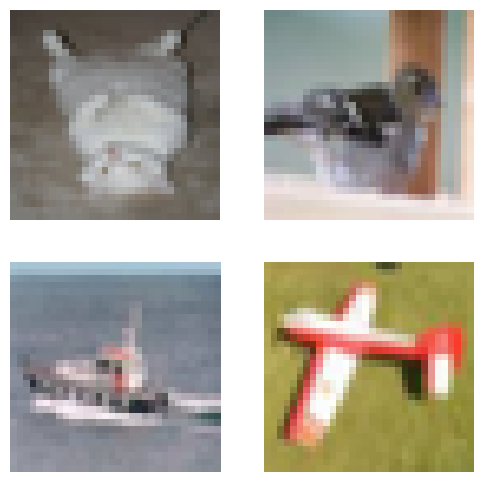

In [ ]:
plt.figure(figsize=(6,6))
k=0
n=4
for i in range(n):
  ax = plt.subplot(2,2,k+1)
  plt.imshow((d[i]+1)/2)
  plt.axis("off")
  k+=1

## Create Generator

In [ ]:
generator = tf.keras.Sequential([
    Input(shape= (LATENT_DIM,)),
    Dense((4*4*LATENT_DIM)),
    Reshape((4,4,LATENT_DIM)),

    Conv2DTranspose(256, kernel_size =4, strides=2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(128, kernel_size =4, strides=2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(3, kernel_size=4, strides = 2, activation='tanh', padding ='same'),

],name = 'generator')

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         409856    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 8, 8, 256)         1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       52

## Discriminator

In [ ]:
discriminator=tf.keras.Sequential([
  Input(shape=(32,32,3)),

  Conv2D(32,kernel_size=4,strides=2, padding='same'),
  LeakyReLU(0.2),

  Conv2D(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(1,kernel_size=4,strides=2, padding='same'),

  Flatten(),
  Dense(1,activation='sigmoid')


],name='discriminator')

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        1568      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         65664     
                                                                 
 batch_normalization_2 (Bat  (None, 8, 8, 128)         512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524544    
                                                     

## Create Model

In [ ]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16,16))
        for i in range(n):
          for j in range(n):
            ax=plt.subplot(n,n,k+1)
            plt.imshow((out[k]+1)/2,)
            plt.axis('off')
            k+=1
        plt.savefig("/content/gdrive/MyDrive/generator/gen_images_epoch_{}.png".format(epoch+1))

- Dữ liệu giả được tạo ra bởi Generator thông qua việc truyền một vector nhiễu ngẫu nhiên (latent vector) có kích thước là LATENT_DIM qua một chuỗi các lớp (layers) và phép biến đổi để tạo ra dữ liệu giả.

In [ ]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')

# metrics giá trị của 2 hàm loss
  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]

    ######## Discriminator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM)) # tạo nhiễu
    fake_images=self.generator(random_noise)  # generation ảnh fake
# tạo nhãn cho ảnh fake
    real_labels=tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
    fake_labels=tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)

# Ghi lại các gradient
    with tf.GradientTape() as recorder:
      real_predictions=self.discriminator(real_images)
      d_loss_real=self.loss_fn(real_labels,real_predictions)

      fake_predictions=self.discriminator(fake_images)
      d_loss_fake=self.loss_fn(fake_labels,fake_predictions)

      d_loss=d_loss_real+d_loss_fake

# Tính gradient và cập nhật các tham số
    partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))


    ############# Generator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    flipped_fake_labels=tf.ones((batch_size,1))

    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)

    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

# cập nhật giá trị của 2 hàm loss
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [ ]:
gan=GAN(discriminator,generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

## Train Model

In [ ]:
EPOCHS=500
history=gan.fit(train_dataset,epochs=EPOCHS,callbacks=[ShowImage(LATENT_DIM)])

Epoch 1/500
469/469 [==============================] - 80s 159ms/step - d_loss: 1.3141 - g_loss: 0.7286
Epoch 2/500
469/469 [==============================] - 19s 40ms/step - d_loss: 1.2984 - g_loss: 0.7173
Epoch 3/500
469/469 [==============================] - 19s 41ms/step - d_loss: 1.2773 - g_loss: 0.7598
Epoch 4/500
469/469 [==============================] - 20s 42ms/step - d_loss: 1.2370 - g_loss: 0.8141
Epoch 5/500
469/469 [==============================] - 19s 41ms/step - d_loss: 1.2161 - g_loss: 0.8642
Epoch 6/500
469/469 [==============================] - 19s 40ms/step - d_loss: 1.2478 - g_loss: 0.7960
Epoch 7/500
469/469 [==============================] - 20s 42ms/step - d_loss: 1.2407 - g_loss: 0.7957
Epoch 8/500
469/469 [==============================] - 19s 40ms/step - d_loss: 1.2416 - g_loss: 0.7831
Epoch 9/500
469/469 [==============================] - 19s 41ms/step - d_loss: 1.2390 - g_loss: 0.7849
Epoch 10/500
469/469 [==============================] - 19s 40ms/step - 

<ipython-input-27-35b3d0d7f918>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,16))


469/469 [==============================] - 20s 43ms/step - d_loss: 1.2538 - g_loss: 0.7420
Epoch 22/500
469/469 [==============================] - 19s 41ms/step - d_loss: 1.2509 - g_loss: 0.7602
Epoch 23/500
469/469 [==============================] - 19s 41ms/step - d_loss: 1.2457 - g_loss: 0.7577
Epoch 24/500
469/469 [==============================] - 19s 41ms/step - d_loss: 1.2408 - g_loss: 0.7657
Epoch 25/500
469/469 [==============================] - 20s 42ms/step - d_loss: 1.2377 - g_loss: 0.7680
Epoch 26/500
469/469 [==============================] - 19s 40ms/step - d_loss: 1.2295 - g_loss: 0.7800
Epoch 27/500
469/469 [==============================] - 20s 42ms/step - d_loss: 1.2200 - g_loss: 0.7924
Epoch 28/500
469/469 [==============================] - 19s 41ms/step - d_loss: 1.2144 - g_loss: 0.7987
Epoch 29/500
469/469 [==============================] - 20s 43ms/step - d_loss: 1.2111 - g_loss: 0.8040
Epoch 30/500
469/469 [==============================] - 19s 41ms/step - d_los

In [ ]:
gan.save('/content/gdrive/MyDrive/Colab Notebooks/gan_model.h5')

In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()